# Fashion MNIST Dataset Introduction
###It contains the following info:

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

####**Content**
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

####**Labels**

Each training and test example is assigned to one of the following labels:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

####**Note**


*   Each row is a separate image
*   Column 1 is the class label.
*   Remaining columns are pixel numbers (784 total).
*   Each value is the darkness of the pixel (1 to 255)

In [ ]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [ ]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


We are only loading the features of train data as we do not require the labels. Then we are dividing each pixel value by 127.5 and subtracting it from 1 to have pixel values in the range of -1 to 1. Finally, the X_train shape is (60000, 28, 28, 1).

In [ ]:
#function to generate latent points of the shape n_samples x latent_dim(100 in our case).
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [ ]:
#helps us to generate n real samples with 1 as a label, i.e. real image.
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [ ]:
#helps us to generate n fake samples using the generator with 0 as a label, i.e. fake image.
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
#helps us to summarize the performance. This includes generating a fake sample, plotting it, and finally saving the model.
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [ ]:
#helps us to plot the results. We’ll use this to plot the generated images by the Generator in later stages.
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

###The Discriminator Model
discriminator = define_discriminator()
We are using couple of Dense, Flatten and Dropout layers with leaky relu as an activation function in hidden layers and sigmoid in the final layer, adam as an optimizer and binary cross-entropy as a loss function as the discriminator’s task is to perform the binary classification.

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

####The Generator Model
generator = define_generator(100)
We are using a couple of Dense layers to define the generator model with again leaky relu as an activation function in hidden layers and tanh in the final layer. The generated images G(z) will be of the shape 28x28x1.

In [ ]:
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

###Model Training
gan_model = define_gan(generator, discriminator)
We are freezing the discriminator, providing z as input and D(G(z)) as an output to our model. We are using adam as an optimizer and binary cross-entropy as a loss function.

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()
generator = define_generator(100)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



This function helps us to train the generator and the discriminator. To train the Discriminator, it first generates real samples, updates the discriminator’s weights, generates fake samples, and then updates the discriminator’s weights again. To train the Generator, it first generates latent points, generates labels as 1 to fool the discriminator, and then updates the generator’s weights. Finally, the function summarizes the performance of the model after some steps.

In [ ]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

In [ ]:
gan_model = define_gan(generator, discriminator)

2/2 [==============================] - 0s 14ms/step
>1, dr[0.219,0.969], df[0.726,0.000], g[0.679,1.000]
2/2 [==============================] - 0s 20ms/step
>2, dr[0.000,1.000], df[0.910,0.000], g[0.605,1.000]
2/2 [==============================] - 0s 13ms/step
>3, dr[0.000,1.000], df[1.130,0.000], g[0.660,0.938]
2/2 [==============================] - 0s 16ms/step
>4, dr[0.005,1.000], df[0.786,0.016], g[1.057,0.000]
2/2 [==============================] - 0s 17ms/step
>5, dr[1.690,0.172], df[0.877,0.000], g[0.556,1.000]
2/2 [==============================] - 0s 19ms/step
>6, dr[0.000,1.000], df[1.401,0.000], g[0.654,0.859]
2/2 [==============================] - 0s 24ms/step
>7, dr[0.005,1.000], df[0.753,0.188], g[1.368,0.000]
2/2 [==============================] - 0s 11ms/step
>8, dr[1.958,0.234], df[0.995,0.000], g[0.456,1.000]
2/2 [==============================] - 0s 11ms/step
>9, dr[0.000,1.000], df[1.625,0.000], g[0.460,1.000]
2/2 [==============================] - 0s 12ms/step
>10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: model_0937.h5
2/2 [==============================] - 0s 10ms/step
>938, dr[0.670,0.484], df[0.579,0.828], g[0.952,0.062]
2/2 [==============================] - 0s 10ms/step
>939, dr[0.661,0.469], df[0.704,0.734], g[0.954,0.094]
2/2 [==============================] - 0s 9ms/step
>940, dr[0.612,0.578], df[0.609,0.797], g[0.975,0.172]
2/2 [==============================] - 0s 8ms/step
>941, dr[0.614,0.562], df[0.830,0.578], g[0.912,0.094]
2/2 [==============================] - 0s 9ms/step
>942, dr[0.651,0.531], df[0.649,0.703], g[0.864,0.188]
2/2 [==============================] - 0s 10ms/step
>943, dr[0.674,0.438], df[0.739,0.594], g[0.900,0.094]
2/2 [==============================] - 0s 10ms/step
>944, dr[0.719,0.328], df[0.613,0.750], g[0.955,0.062]
2/2 [==============================] - 0s 11ms/step
>945, dr[0.702,0.484], df[0.640,0.766], g[1.018,0.047]
2/2 [==============================] - 0s 10ms/step
>946, dr[0.749,0.312], df[0.563,0.875], g[1.033,0.047]
2/2 [=============

>Saved: model_1874.h5
2/2 [==============================] - 0s 16ms/step
>1875, dr[0.682,0.453], df[0.663,0.703], g[0.872,0.078]
2/2 [==============================] - 0s 11ms/step
>1876, dr[0.642,0.516], df[0.626,0.766], g[0.939,0.078]
2/2 [==============================] - 0s 12ms/step
>1877, dr[0.648,0.547], df[0.694,0.656], g[0.881,0.156]
2/2 [==============================] - 0s 9ms/step
>1878, dr[0.619,0.484], df[0.662,0.781], g[0.853,0.234]
2/2 [==============================] - 0s 10ms/step
>1879, dr[0.635,0.469], df[0.776,0.656], g[1.051,0.078]
2/2 [==============================] - 0s 10ms/step
>1880, dr[0.676,0.344], df[0.639,0.734], g[0.873,0.047]
2/2 [==============================] - 0s 10ms/step
>1881, dr[0.704,0.375], df[0.666,0.672], g[0.893,0.109]
2/2 [==============================] - 0s 10ms/step
>1882, dr[0.707,0.406], df[0.635,0.750], g[0.941,0.047]
2/2 [==============================] - 0s 10ms/step
>1883, dr[0.686,0.406], df[0.687,0.672], g[0.886,0.109]
2/2 [==

>Saved: model_2811.h5
2/2 [==============================] - 0s 10ms/step
>2812, dr[0.625,0.609], df[0.675,0.766], g[1.036,0.109]
2/2 [==============================] - 0s 11ms/step
>2813, dr[0.623,0.609], df[0.715,0.562], g[1.293,0.094]
2/2 [==============================] - 0s 10ms/step
>2814, dr[0.691,0.438], df[0.570,0.797], g[0.977,0.047]
2/2 [==============================] - 0s 9ms/step
>2815, dr[0.611,0.562], df[0.656,0.719], g[0.965,0.125]
2/2 [==============================] - 0s 10ms/step
>2816, dr[0.572,0.656], df[0.702,0.703], g[1.011,0.188]
2/2 [==============================] - 0s 11ms/step
>2817, dr[0.595,0.578], df[0.699,0.734], g[0.930,0.156]
2/2 [==============================] - 0s 11ms/step
>2818, dr[0.586,0.562], df[0.648,0.703], g[1.068,0.109]
2/2 [==============================] - 0s 9ms/step
>2819, dr[0.536,0.625], df[0.622,0.750], g[1.078,0.141]
2/2 [==============================] - 0s 12ms/step
>2820, dr[0.709,0.516], df[0.724,0.672], g[1.023,0.062]
2/2 [===

>Saved: model_3748.h5
2/2 [==============================] - 0s 10ms/step
>3749, dr[0.510,0.703], df[0.725,0.672], g[1.442,0.078]
2/2 [==============================] - 0s 9ms/step
>3750, dr[0.566,0.672], df[0.680,0.609], g[1.415,0.078]
2/2 [==============================] - 0s 13ms/step
>3751, dr[0.534,0.609], df[0.574,0.766], g[1.387,0.094]
2/2 [==============================] - 0s 11ms/step
>3752, dr[0.414,0.766], df[0.553,0.859], g[1.437,0.062]
2/2 [==============================] - 0s 9ms/step
>3753, dr[0.436,0.750], df[0.474,0.797], g[1.918,0.031]
2/2 [==============================] - 0s 10ms/step
>3754, dr[0.746,0.594], df[0.437,0.844], g[1.326,0.125]
2/2 [==============================] - 0s 12ms/step
>3755, dr[0.373,0.812], df[0.690,0.688], g[1.277,0.062]
2/2 [==============================] - 0s 12ms/step
>3756, dr[0.624,0.562], df[0.650,0.797], g[1.315,0.062]
2/2 [==============================] - 0s 12ms/step
>3757, dr[0.577,0.656], df[0.598,0.844], g[1.340,0.125]
2/2 [===

>Saved: model_4685.h5
2/2 [==============================] - 0s 15ms/step
>4686, dr[0.715,0.375], df[0.663,0.734], g[1.199,0.062]
2/2 [==============================] - 0s 8ms/step
>4687, dr[0.818,0.438], df[0.583,0.766], g[1.026,0.203]
2/2 [==============================] - 0s 13ms/step
>4688, dr[0.551,0.625], df[0.489,0.891], g[1.274,0.125]
2/2 [==============================] - 0s 11ms/step
>4689, dr[0.626,0.609], df[0.621,0.797], g[1.222,0.109]
2/2 [==============================] - 0s 18ms/step
>4690, dr[0.761,0.438], df[0.528,0.828], g[1.082,0.125]
2/2 [==============================] - 0s 12ms/step
>4691, dr[0.676,0.531], df[0.701,0.734], g[1.091,0.172]
2/2 [==============================] - 0s 10ms/step
>4692, dr[0.696,0.453], df[0.799,0.703], g[1.121,0.125]
2/2 [==============================] - 0s 12ms/step
>4693, dr[0.705,0.516], df[0.690,0.719], g[1.111,0.109]
2/2 [==============================] - 0s 9ms/step
>4694, dr[0.669,0.484], df[0.624,0.688], g[1.111,0.156]
2/2 [===

>Saved: model_5622.h5
2/2 [==============================] - 0s 18ms/step
>5623, dr[0.516,0.703], df[0.548,0.828], g[1.238,0.172]
2/2 [==============================] - 0s 15ms/step
>5624, dr[0.731,0.578], df[0.604,0.781], g[1.256,0.094]
2/2 [==============================] - 0s 9ms/step
>5625, dr[0.599,0.641], df[0.595,0.734], g[1.261,0.156]
2/2 [==============================] - 0s 9ms/step
>5626, dr[0.571,0.641], df[0.614,0.750], g[1.415,0.094]
2/2 [==============================] - 0s 19ms/step
>5627, dr[0.435,0.781], df[0.672,0.719], g[1.210,0.250]
2/2 [==============================] - 0s 11ms/step
>5628, dr[0.675,0.594], df[0.687,0.625], g[1.305,0.109]
2/2 [==============================] - 0s 16ms/step
>5629, dr[0.619,0.625], df[0.540,0.797], g[1.098,0.219]
2/2 [==============================] - 0s 9ms/step
>5630, dr[0.623,0.625], df[0.721,0.531], g[1.206,0.094]
2/2 [==============================] - 0s 11ms/step
>5631, dr[0.604,0.609], df[0.483,0.844], g[1.685,0.109]
2/2 [====

>Saved: model_6559.h5
2/2 [==============================] - 0s 10ms/step
>6560, dr[0.702,0.531], df[0.654,0.703], g[1.238,0.094]
2/2 [==============================] - 0s 15ms/step
>6561, dr[0.713,0.438], df[0.682,0.672], g[1.122,0.141]
2/2 [==============================] - 0s 9ms/step
>6562, dr[0.602,0.609], df[0.703,0.719], g[1.176,0.156]
2/2 [==============================] - 0s 16ms/step
>6563, dr[0.565,0.656], df[0.585,0.703], g[1.112,0.109]
2/2 [==============================] - 0s 10ms/step
>6564, dr[0.615,0.578], df[0.515,0.812], g[1.164,0.234]
2/2 [==============================] - 0s 11ms/step
>6565, dr[0.553,0.656], df[0.544,0.766], g[1.165,0.250]
2/2 [==============================] - 0s 19ms/step
>6566, dr[0.658,0.641], df[0.581,0.766], g[1.220,0.172]
2/2 [==============================] - 0s 21ms/step
>6567, dr[0.553,0.672], df[0.799,0.594], g[1.073,0.141]
2/2 [==============================] - 0s 12ms/step
>6568, dr[0.624,0.578], df[0.576,0.766], g[1.458,0.141]
2/2 [==

>Saved: model_7496.h5
2/2 [==============================] - 0s 9ms/step
>7497, dr[0.609,0.641], df[0.669,0.719], g[1.270,0.156]
2/2 [==============================] - 0s 10ms/step
>7498, dr[0.619,0.625], df[0.563,0.766], g[1.256,0.141]
2/2 [==============================] - 0s 10ms/step
>7499, dr[0.624,0.625], df[0.440,0.828], g[1.306,0.172]
2/2 [==============================] - 0s 12ms/step
>7500, dr[0.553,0.609], df[0.677,0.703], g[1.216,0.188]
2/2 [==============================] - 0s 10ms/step
>7501, dr[0.576,0.688], df[0.750,0.641], g[1.293,0.125]
2/2 [==============================] - 0s 16ms/step
>7502, dr[0.795,0.438], df[0.558,0.766], g[1.319,0.109]
2/2 [==============================] - 0s 10ms/step
>7503, dr[0.647,0.578], df[0.593,0.781], g[1.141,0.094]
2/2 [==============================] - 0s 10ms/step
>7504, dr[0.702,0.531], df[0.618,0.688], g[1.136,0.188]
2/2 [==============================] - 0s 9ms/step
>7505, dr[0.599,0.578], df[0.656,0.703], g[1.432,0.156]
2/2 [===

>Saved: model_8433.h5
2/2 [==============================] - 0s 8ms/step
>8434, dr[0.594,0.547], df[0.628,0.719], g[1.485,0.094]
2/2 [==============================] - 0s 9ms/step
>8435, dr[0.751,0.484], df[0.610,0.750], g[1.221,0.141]
2/2 [==============================] - 0s 12ms/step
>8436, dr[0.655,0.578], df[0.531,0.750], g[1.321,0.109]
2/2 [==============================] - 0s 9ms/step
>8437, dr[0.552,0.641], df[0.578,0.734], g[1.485,0.078]
2/2 [==============================] - 0s 11ms/step
>8438, dr[0.609,0.672], df[0.660,0.672], g[1.231,0.094]
2/2 [==============================] - 0s 10ms/step
>8439, dr[0.635,0.578], df[0.585,0.797], g[1.478,0.094]
2/2 [==============================] - 0s 11ms/step
>8440, dr[0.485,0.797], df[0.515,0.859], g[1.432,0.156]
2/2 [==============================] - 0s 11ms/step
>8441, dr[0.670,0.656], df[0.703,0.719], g[1.423,0.078]
2/2 [==============================] - 0s 9ms/step
>8442, dr[0.556,0.703], df[0.572,0.766], g[1.436,0.172]
2/2 [=====

>Saved: model_9370.h5
2/2 [==============================] - 0s 12ms/step
>9371, dr[0.599,0.672], df[0.776,0.625], g[1.209,0.125]
2/2 [==============================] - 0s 11ms/step
>9372, dr[0.528,0.656], df[0.739,0.641], g[1.193,0.188]
2/2 [==============================] - 0s 11ms/step
>9373, dr[0.553,0.688], df[0.445,0.859], g[1.456,0.109]
2/2 [==============================] - 0s 14ms/step
>9374, dr[0.686,0.531], df[0.574,0.688], g[1.276,0.172]
2/2 [==============================] - 0s 11ms/step
>9375, dr[0.533,0.641], df[0.661,0.766], g[1.412,0.062]
2/2 [==============================] - 0s 9ms/step
>9376, dr[0.669,0.547], df[0.618,0.703], g[1.234,0.156]
2/2 [==============================] - 0s 13ms/step
>9377, dr[0.682,0.516], df[0.698,0.625], g[1.198,0.156]
2/2 [==============================] - 0s 11ms/step
>9378, dr[0.647,0.562], df[0.674,0.656], g[1.200,0.172]
2/2 [==============================] - 0s 22ms/step
>9379, dr[0.714,0.469], df[0.570,0.766], g[1.245,0.203]
2/2 [==

>Saved: model_10307.h5
2/2 [==============================] - 0s 10ms/step
>10308, dr[0.624,0.594], df[0.517,0.797], g[1.303,0.062]
2/2 [==============================] - 0s 12ms/step
>10309, dr[0.607,0.547], df[0.667,0.719], g[1.118,0.188]
2/2 [==============================] - 0s 11ms/step
>10310, dr[0.571,0.609], df[0.682,0.688], g[1.253,0.109]
2/2 [==============================] - 0s 9ms/step
>10311, dr[0.572,0.641], df[0.615,0.688], g[1.349,0.078]
2/2 [==============================] - 0s 17ms/step
>10312, dr[0.694,0.547], df[0.455,0.844], g[1.284,0.125]
2/2 [==============================] - 0s 16ms/step
>10313, dr[0.722,0.547], df[0.755,0.719], g[1.376,0.062]
2/2 [==============================] - 0s 12ms/step
>10314, dr[0.737,0.484], df[0.672,0.703], g[1.173,0.188]
2/2 [==============================] - 0s 13ms/step
>10315, dr[0.507,0.750], df[0.489,0.797], g[1.183,0.172]
2/2 [==============================] - 0s 13ms/step
>10316, dr[0.654,0.609], df[0.574,0.750], g[1.384,0.10

KeyboardInterrupt: 

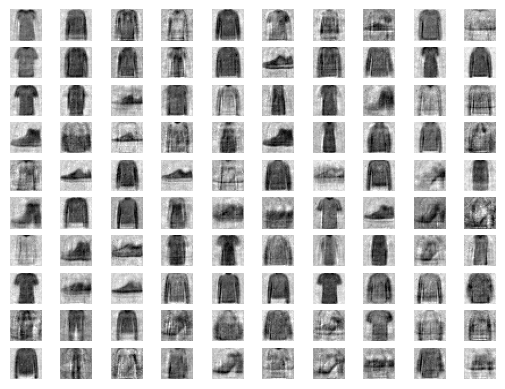

In [ ]:
#finally calling the train function with 100 random samples, 20 epochs, and 64 as batch size.
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)